# Coding Project for Deep Learning at BHT (Bießmann)
## Color Specific Digit Recognizer of Cash Receipt Images (by Leon Ostermann)
### for detecting and predicting the color highlighted numbers from cash receipt images

In [1]:
from PIL import Image
import numpy as np
import imutils
import cv2

In [2]:
# Display the result
def plot_results(image, mode="inline", scale=0.6):
    if mode == "popup":
        pass
    elif mode == "inline":
        image = Image.fromarray(image)
    else:
        raise ValueError("Mode must be either 'popup' or 'inline'")

    if type(image) is np.ndarray:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        width, height = image.size
        display(image.resize((int(width*scale), int(height*scale))))

## Foreword:

Because directly highlighting the numbers on the receipts results in noise/fragments in the images, I now only highlight a fixed point to the right of the numbers and move the "detection box" in the preprocessing to the left with an fixed offset.

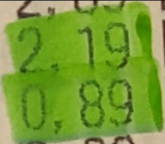

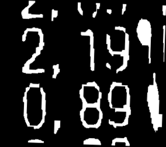

In [3]:
colored_cutout = cv2.imread("receipts/processed/REWE_color_processed_cutout.jpg")
preprocessed_cutout = cv2.imread("receipts/processed/multi.jpg")

plot_results(colored_cutout)
plot_results(preprocessed_cutout, scale=0.49)

## Hence the new (color) detection method:

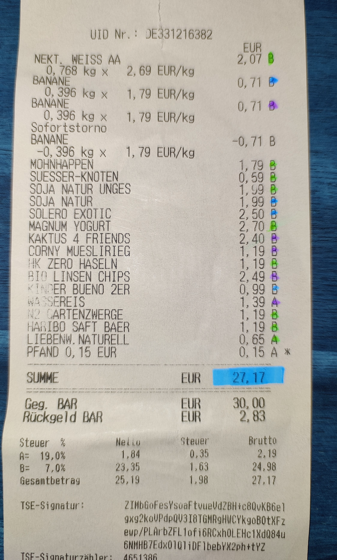

In [4]:
file_name_load = "test_color_dots"
image_path = f"receipts/raw/{file_name_load}.jpg"
# TODO why not original coloration?
raw_image = cv2.imread(image_path)#[:,:,0]
plot_results(raw_image, scale=0.15)

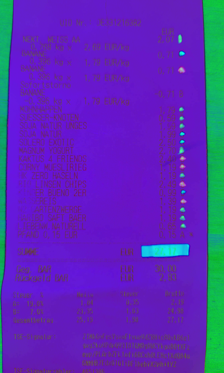

In [5]:
hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)
plot_results(hsv_image, scale=0.1)

In [6]:
## set color to detect (green in this case)

## Hue, Saturation, Value
## Hue: 0-180, Saturation: 0-255, Value: 0-255

## np.array([H {0-180}, S {0-255}, V {0-255}}])
lower = np.array([30, 50, 20])
upper = np.array([90, 255, 255])

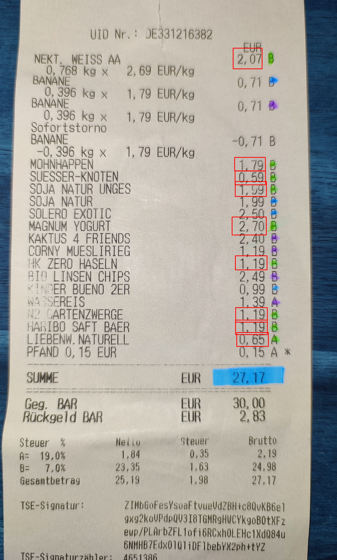

In [7]:
# Create a binary mask for the specified color
mask = cv2.inRange(hsv_image, lower, upper)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to store the regions inside bounding boxes
result_image = raw_image.copy()

boxs_coordinates = []
# Draw bounding rectangles around the detected contours
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if all([w > 10, h > 10, w > 10, h > 10]):
        x -= 230
        w += 150
        y -= 20
        h += 40
        cv2.rectangle(result_image, ((x), y), ((x) + w, y + h), (255, 0, 0), 3)  # Green rectangle
        boxs_coordinates.append((x, y, x + w, y + h))
        # print(contour)
    else:
        pass

plot_results(result_image, scale=0.15)

## PREVIOUS APPROACHES

### HUGGING FACE MODEL (DONUT)

See results here (or in screencast):

Quick_inference_with_DONUT_for_Document_Parsing.ipynb

### PYTESSERACT

In [8]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

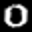

No valid number detected.


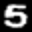

Detected number: 5


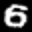

Detected number: 6


In [9]:
for i in [0, 5, 6]:

   img = Image.open(fr"D:\Dokumente_D\bht_documents\02_deep_learning\coding_project\receipts\processed\{i}_resized.png")

   plot_results(img, "popup", scale=2)

   # Perform OCR to recognize the number
   number_text = pytesseract.image_to_string(img, config='--psm 6')

   # Clean up the recognized text (remove non-numeric characters)
   cleaned_number = ''.join(filter(str.isdigit, number_text))

   # Convert the cleaned text to an integer (if it's a valid number)
   try:
      detected_number = int(cleaned_number)
      print(f"Detected number: {detected_number}")
   except ValueError:
      print("No valid number detected.")

### DIGITAL NUMBERS RECOGNIZER

In [10]:
from imutils import contours
import imutils

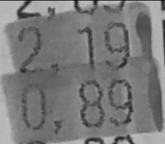

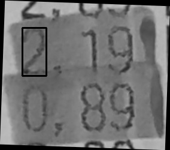

prediction for picture above: 2


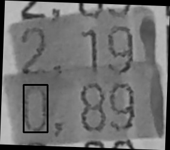

prediction for picture above: None


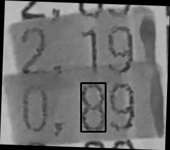

prediction for picture above: 8


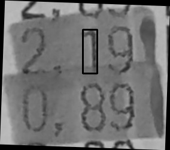

prediction for picture above: 7


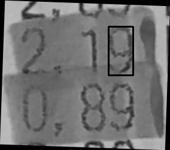

prediction for picture above: 4


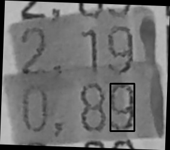

prediction for picture above: None


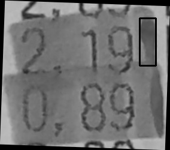

prediction for picture above: None


In [11]:
file_name_load = "REWE_color_processed_cutout"
image_path = f"receipts/processed/{file_name_load}.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# image = cv2.imread(image_path)[:,:,0]

plot_results(image)

NO_NOISE = False

DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 0, 0, 0, 1): 2, # for 2's with diagonal line
	# (1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

# Apply the contrast adjustment
adjusted_image = np.clip(image * 1, 80, 105).astype(np.uint8)

# convert image to grayscale, threshold and then apply a series of morphological
# operations to cleanup the thresholded image
_, thresholded_image = cv2.threshold(adjusted_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
result = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)

# Join the fragmented digit parts
kernel = np.ones((9,11),np.uint8)
dilation = cv2.dilate(result,kernel,iterations = 1)
erosion = cv2.erode(dilation,kernel,iterations = 1)

# Rotate the image, so the digits are straight
rotation = +2
erosion = imutils.rotate_bound(erosion, rotation)

# find contours in the thresholded image, and put bounding box on the image
cnts = cv2.findContours(erosion.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
image_w_bbox = image.copy()
image_w_bbox = imutils.rotate_bound(image_w_bbox, rotation)
#print("Printing (x, y, w, h) for each each bounding rectangle found in the image...")
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    #  print(x, y, w, h)
    # if the contour is sufficiently large, it must be a digit
    if w >= 10 and (h >= 50 and h <= 100):
        digitCnts.append(c)
        image_w_bbox = cv2.rectangle(image_w_bbox,(x, y),(x+w, y+h),(0, 255, 0),2)

# # Display the result
# plot_results(image_w_bbox)

# sort the contours from left-to-right
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
# len(digitCnts) # to check how many digits have been recognized

digits = []
# loop over each of the digits
for c in digitCnts:
    
    # extract the digit ROI
    (x, y, w, h) = cv2.boundingRect(c)
    current_state_image = cv2.rectangle(imutils.rotate_bound(image, rotation),(x, y),(x+w, y+h),(0, 255, 0),2)
    if w < 35 and NO_NOISE : # it turns out we can recognize number 1 based on the ROI width
        digits.append(1)
        print(1)
        # # Display the result
        # plot_results(current_state_image)
    else: # for digits othan than the number 1

        roi = erosion[y:y + h, x:x + w]
        # compute the width and height of each of the 7 segments we are going to examine
        (roiH, roiW) = roi.shape
        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)

        # define the set of 7 segments
        segments = [
            ((0, 0), (w, dH)),	# top
            ((0, 0), (dW, h // 2)),	# top-left
            ((w - dW, 0), (w, h // 2)),	# top-right
            ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
            ((0, h // 2), (dW, h)),	# bottom-left
            ((w - dW, h // 2), (w, h)),	# bottom-right
            ((0, h - dH), (w, h))	# bottom
        ]
        on = [0] * len(segments)

        # loop over the segments
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):

            # extract the segment ROI, count the total number of thresholded pixels
            # in the segment, and then compute the area of the segment
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)

            # if the total number of non-zero pixels is greater than
            # 40% of the area, mark the segment as "on"
            if total / float(area) > 0.4:
                on[i]= 1

        # lookup the digit and draw it on the image
        try:
            digit = DIGITS_LOOKUP[tuple(on)]
            digits.append(digit)
        except:
            digit = None
            digits.append(digit)

        # Display the result
        plot_results(current_state_image)
        print(f"prediction for picture above: {digit}")

## KERAS TENSORFLOW MODEL (MNIST DATASET)

In [12]:
import tensorflow as tf

In [13]:
# mnist = tf.keras.datasets.mnist
# (x_train, y_train),(x_test, y_test) = mnist.load_data()

# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dense(10, activation="softmax"))

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# model.fit(x_train, y_train, epochs=27)

# loss, accuracy = model.evaluate(x_test, y_test)
# print(loss, accuracy)

# # model.save("digits.model")

Epoch 1/27
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2640 - accuracy: 0.9221
Epoch 2/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1075 - accuracy: 0.9670
Epoch 3/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0732 - accuracy: 0.9763
Epoch 4/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0551 - accuracy: 0.9826
Epoch 5/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0421 - accuracy: 0.9864
Epoch 6/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0316 - accuracy: 0.9895
Epoch 7/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0261 - accuracy: 0.9913
Epoch 8/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0203 - accuracy: 0.9930
Epoch 9/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0168 - accuracy: 0.9943
Epoch 10/27
1875/1875 [==============================] - 3s 2ms/step - loss: 0.016

In [13]:
model = tf.keras.models.load_model("digits.model")

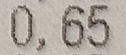

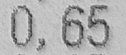

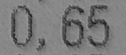

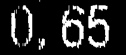

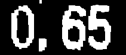

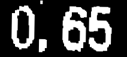

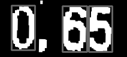

1/1 [==============================] - 0s 190ms/step


Prediction: 5
1/1 [==============================] - 0s 20ms/step


Prediction: 6
1/1 [==============================] - 0s 20ms/step


Prediction: 0


In [14]:
plot = True
results = True
for coordinates in boxs_coordinates:
    x1, y1, x2, y2 = coordinates

    # Crop the image using the coordinates
    cropped_image = raw_image[y1:y2, x1:x2]
    if plot and results: plot_results(cropped_image)

    # gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    gray_image = cropped_image[:,:,0]
    if plot and results: plot_results(gray_image)

    # Apply the contrast adjustment
    adjusted_image = np.clip(gray_image * 0.7, 0, 255).astype(np.uint8)
    if plot and results: plot_results(adjusted_image)

    # convert image to grayscale, threshold and then apply a series of morphological operations to cleanup the thresholded image
    _, thresholded_image = cv2.threshold(adjusted_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
    bw_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel)
    if plot and results: plot_results(bw_image)

    # Join the fragmented digit parts
    # TODO figure out kernel size
    x_lim, y_lim = 4, 4
    kernel = np.ones((x_lim, y_lim),np.uint8)
    dilation = cv2.dilate(bw_image,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    if plot and results: plot_results(erosion)

    # Rotate the image, so the digits are straight
    rotation = +1
    erosion_rot = imutils.rotate_bound(erosion, rotation)
    if plot and results: plot_results(erosion_rot)

    # find contours in the thresholded image, and put bounding box on the image
    cnts = cv2.findContours(erosion_rot.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    image_w_bbox = erosion_rot.copy()
    digitCnts = []
    # loop over the digit area candidates
    #print("Printing (x, y, w, h) for each each bounding rectangle found in the image...")
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        #  print(x, y, w, h)
        # if the contour is sufficiently large, it must be a digit
        if w >= 10 and (h >= 50 and h <= 100):
            digitCnts.append(c)
            # TODO why only gray scale instead of color?
            image_w_bbox = cv2.rectangle(image_w_bbox,(x, y),(x+w, y+h),(100, 100, 100),2)

    # Display the result
    if plot and results: plot_results(image_w_bbox)

    digits = []
    # loop over each of the digits
    for c in digitCnts:
        # extract the digit ROI
        (x, y, w, h) = cv2.boundingRect(c)
        current_state_image = cv2.rectangle(adjusted_image,(x, y),(x+w, y+h),(0, 255, 0),2)
        roi = erosion_rot[y:y + h, x:x + w]
        img = cv2.resize(roi, (28, 28))

        # Define the target size (e.g., 20x20)
        target_size = (20, 20)
        # Resize the image while maintaining its aspect ratio
        resized_image = cv2.resize(img, target_size)
        # Calculate the padding needed to make it 28x28
        padding_x = (28 - target_size[0]) // 2
        padding_y = (28 - target_size[1]) // 2
        # Create a black canvas with the size 28x28
        canvas_0 = np.zeros((28, 28), dtype=np.uint8)
        # Paste the resized image onto the canvas, filling the borders with black
        canvas_0[padding_y:padding_y+target_size[1], padding_x:padding_x+target_size[0]] = resized_image

        img_pred = np.array([canvas_0])
            
        predictions = model.predict([img_pred])

        if plot:
            plot_results(roi)
            plot_results(img)
            plot_results(canvas_0)
            print(f"Prediction: {np.argmax(predictions)}")
            # break
    results = False
    if plot: break

## GOOGLE VISION AI

In [15]:
import os
import re
from google.cloud import vision

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"D:\Dokumente_D\Gits\Keys\pythonreceipts-43e91022a1fa.json"
client = vision.ImageAnnotatorClient()

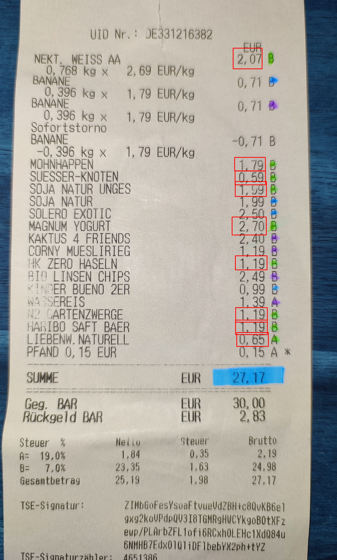

In [16]:
plot_results(result_image, scale=0.15)

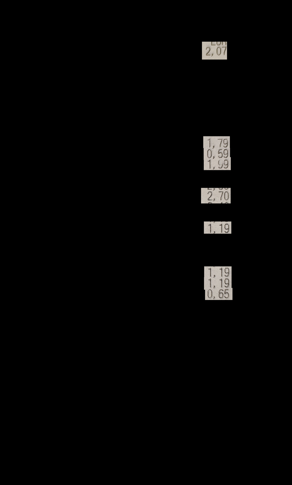

In [17]:
# Create a black canvas with the same size as the original image
canvas = np.zeros_like(result_image)

image_snippets=[]
# Copy the regions inside bounding boxes to the canvas
for coordinates in boxs_coordinates:
    x1, y1, x2, y2 = coordinates
    canvas[y1:y2, x1:x2] = raw_image[y1:y2, x1:x2]
    image_snippets.append(raw_image[y1:y2, x1:x2])

plot_results(canvas, "inline", 0.13)

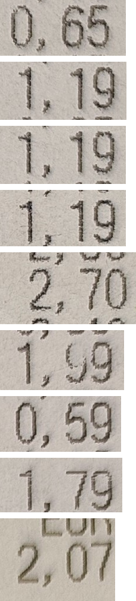

In [18]:
# Define the dimensions of the canvas
max_width = np.max([Image.fromarray(image_snippet).width for image_snippet in image_snippets])
total_height = np.sum([Image.fromarray(image_snippet).height for image_snippet in image_snippets])
canvas_width = max_width
image_spacing = 10
canvas_height = total_height + image_spacing * len(image_snippets) - image_spacing

# Create an empty canvas
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

x_offset = 0
y_offset = 0
## paste images onto canvas to reduce api calls
for te in image_snippets:
    image = Image.fromarray(te)

    # Paste the image onto the canvas at the calculated position
    canvas.paste(image, (x_offset, y_offset))

    y_offset = (y_offset + image.height + image_spacing)

# Display the final canvas
plot_results(canvas, "popup")

# convert to array for google vision ai
canvas_array = np.array(canvas)

In [19]:
_, image_bytes = cv2.imencode('.jpg', canvas_array)
image_data = image_bytes.tobytes()

google_image = vision.Image(content=image_data)

response = client.text_detection(image=google_image)
texts = response.text_annotations
text = texts[0].description
text

'0,65\n1,19\n1,19\n1,19\n2,70\n1,99\n0,59\n1,79\n2.07'

In [20]:
## clean text
text = text.replace(",", ".")
number_string = re.sub(r'[^0-9.,\n]', '', text)
print(number_string)

0.65
1.19
1.19
1.19
2.70
1.99
0.59
1.79
2.07


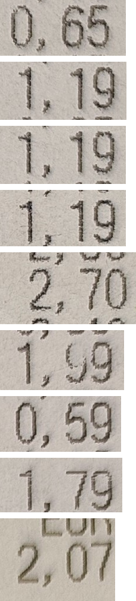

In [21]:
plot_results(canvas, "popup")


In [22]:
number_string_split = [val for val in number_string.split("\n") if len(val) > 0]
numbers = [float(val) for val in number_string_split]
print(f"{number_string_split}\n\n{numbers}")
print(f"\nTotal value of selected purchases:\n{np.sum(numbers)}€")

['0.65', '1.19', '1.19', '1.19', '2.70', '1.99', '0.59', '1.79', '2.07']

[0.65, 1.19, 1.19, 1.19, 2.7, 1.99, 0.59, 1.79, 2.07]

Total value of selected purchases:
13.36€


# SOURCES

GitHub Copilot and ChatGPT were used in part to support the programming and research.

### Color Detection in Python

https://youtu.be/cMJwqxskyek?si=xzBcSYv-GtlEkYiR

### Keras Tensorflow (MNIST)

https://www.youtube.com/watch?v=bte8Er0QhDg

### Google Vision AI:

https://cloud.google.com/vision#section-8

https://www.youtube.com/watch?v=kZ3OL3AN_IA

https://www.youtube.com/watch?v=ddWRX2Y71RU

### OCR Donut CORD:

https://huggingface.co/jinhybr/OCR-Donut-CORD

https://huggingface.co/docs/transformers/main/en/model_doc/donut

https://huggingface.co/spaces/nielsr/donut-cord

https://github.com/clovaai/donut

### Pytesseract:

https://youtu.be/PY_N1XdFp4w?si=XO84tFt9yWv04FkN

### Digital numbers recognizer:

https://github.com/ved-sharma/Digits_recognition_OpenCV_Python/blob/main/Digit_Recognizer_using_OpenCV_Python.ipynb